In [1]:
import sys
sys.path.append('..')
import config as conf
# import functions.parallelization_functions as parallel_funcs

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

# import statistics
# import multiprocessing as mp
import numpy as np
import pandas as pd
# import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from statistics import NormalDist

<a name="block_size"></a>
### 1. Experiment 1: block size by lag order and difference degree

In [2]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_value,MBD_prediction,MBD_inputs,MBD_actual,fit_residuals,AIC,BIC
0,0,control,9,0,0,0,0.006064,1.898668,"[1.8618861, 1.8618861, 1.863039, 1.8814849, 1....",1.910217,[0.0],0.000000,0.000000
1,0,ARIMA,9,0,0,0,0.015487,1.880861,"[1.8618861, 1.8618861, 1.863039, 1.8814849, 1....",1.910217,"[-0.018975000001627773, -0.018975000001627773,...",-39.901334,-39.742451
2,0,control,9,0,0,0,0.076923,2.818778,"[2.5394225, 2.4984641, 2.5803809, 2.5701413, 2...",3.044281,[0.0],0.000000,0.000000
3,0,ARIMA,9,0,0,0,0.142128,2.640311,"[2.5394225, 2.4984641, 2.5803809, 2.5701413, 2...",3.044281,"[-0.10088868452624311, -0.14184708452624317, -...",-9.427925,-9.269042
4,0,control,9,0,0,0,0.000000,1.071322,"[0.97898072, 1.0077742, 0.9981764, 1.0173721, ...",1.071322,[0.0],0.000000,0.000000


In [12]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby([
    'sample',
    'model_type',
    'block_size',
    'lag_order',
    'difference_degree',
    'moving_average_order'
])[['SMAPE_value']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_value': 'SMAPE_score'})

# Add log SMAPE score column for plotting
sample_smape_scores_df['log_SMAPE_score'] = np.log(sample_smape_scores_df['SMAPE_score'].astype(float))

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_score,log_SMAPE_score
0,0,ARIMA,9,0,0,0,3.684675,1.304182
1,0,ARIMA,9,0,1,0,0.953056,-0.048081
2,0,ARIMA,9,0,2,0,3.036465,1.110694
3,0,ARIMA,9,1,0,0,1.699653,0.530424
4,0,ARIMA,9,1,1,0,3.632579,1.289943


In [4]:
# Get the best control sample mean SMAPE score from this experiment so that we can add
# it to the plots for comparison
sample_smape_means = sample_smape_scores_df.groupby(['model_type', 'lag_order', 'difference_degree', 'moving_average_order'])[['SMAPE_score']].mean()
sample_smape_means.reset_index(inplace=True, drop=False)
winning_control_smape_means = sample_smape_means[sample_smape_means['model_type'] == 'control'].sort_values(by=['SMAPE_score'])
winning_control_smape_means.reset_index(inplace=True, drop=True)
winning_control_smape = winning_control_smape_means['SMAPE_score'].iloc[0]

print(f'Winning control sample mean SMAPE score: {winning_control_smape}')

In [5]:
lag_orders = list(sample_smape_scores_df.lag_order.unique())
difference_degrees = list(sample_smape_scores_df.difference_degree.unique())
moving_average_orders = list(sample_smape_scores_df.moving_average_order.unique())
block_sizes = list(sample_smape_scores_df.block_size.unique())

In [6]:
# Find the experiment-wide max SMAPE score so that we can set a common Y-scale for all
# of the subplots
max_smape_score = sample_smape_scores_df[sample_smape_scores_df['model_type'] == 'ARIMA'].sort_values(by=['SMAPE_score'], ascending=False)
max_smape_score.reset_index(inplace=True, drop=True)
max_smape_score = max_smape_score['SMAPE_score'].iloc[0]

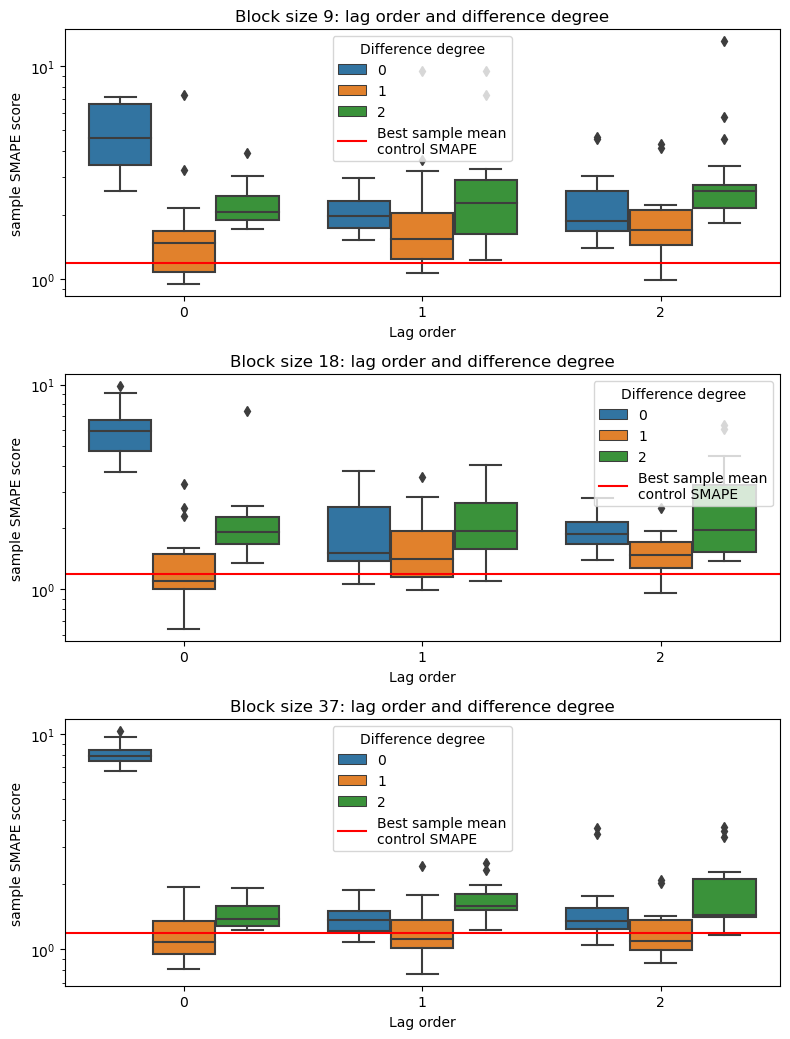

In [14]:
# Plot
fig, ax = plt.subplots(len(block_sizes), 1, figsize=(8, (3.5 * len(block_sizes))))

for plot_num, block_size in enumerate(block_sizes):

    sns.boxplot(
        data=sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'ARIMA') & (sample_smape_scores_df['block_size'] == block_size)], 
        x='lag_order',
        y='SMAPE_score',
        hue='difference_degree',
        ax=ax[plot_num]
    )

    # Set common y limit
    #ax[plot_num].set_ylim([0, max_smape_score + (0.1*max_smape_score)])
    ax[plot_num].set(yscale="log")

    # Add line for best control sample mean
    ax[plot_num].axhline(winning_control_smape, 0, 1, color='red', label=f'Best sample mean\ncontrol SMAPE')

    # Labels
    ax[plot_num].set(
        xlabel='Lag order', 
        ylabel='sample SMAPE score', 
        title=f'Block size {block_size}'
    )

    ax[plot_num].legend(title='Difference degree')

plt.tight_layout()
plt.show()